### DNN(딥러닝), Pytorch 모델로 필기체 숫자 인식

#### 딥러닝으로 가기 전 - 머신러닝

0.9833333333333333
[7]


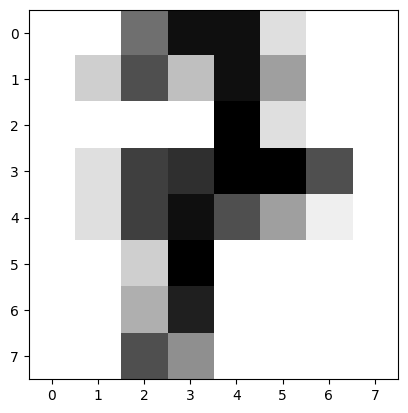

In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()
plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')

n_samples = len (digits.images)
data = digits.images.reshape((n_samples, -1))

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier (n_neighbors=6)

X_train, X_test, y_train, y_test = train_test_split( data, digits.target, test_size=0.2)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

scores = metrics.accuracy_score (y_test, y_pred)
print(scores)

plt.imshow(X_test[10].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
y_pred = knn.predict([X_test[10]])

print(y_pred)

#### 딥러닝(DNN)으로 해 보기!

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# 데이터 로드
digits = datasets.load_digits()
X = digits.data  # (1797, 64)
y = digits.target

In [4]:
# 정규화
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [5]:
# train/test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tensor 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [6]:
# DataLoader 생성
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)


In [13]:
# MLP 모델 정의
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    
    def forward(self, x):
        return self.net(x)

model = DNN()

# 학습 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [14]:
# 학습

from sklearn.metrics import f1_score
import torch.nn.functional as F

# 학습 루프
for epoch in range(20):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"[DNN] Epoch {epoch+1:2d} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")


[DNN] Epoch  1 | Loss: 1.8485 | Accuracy: 0.6026
[DNN] Epoch  2 | Loss: 0.6094 | Accuracy: 0.8796
[DNN] Epoch  3 | Loss: 0.2320 | Accuracy: 0.9457
[DNN] Epoch  4 | Loss: 0.1319 | Accuracy: 0.9722
[DNN] Epoch  5 | Loss: 0.0872 | Accuracy: 0.9826
[DNN] Epoch  6 | Loss: 0.0605 | Accuracy: 0.9896
[DNN] Epoch  7 | Loss: 0.0443 | Accuracy: 0.9944
[DNN] Epoch  8 | Loss: 0.0333 | Accuracy: 0.9958
[DNN] Epoch  9 | Loss: 0.0251 | Accuracy: 0.9972
[DNN] Epoch 10 | Loss: 0.0203 | Accuracy: 0.9972
[DNN] Epoch 11 | Loss: 0.0159 | Accuracy: 0.9986
[DNN] Epoch 12 | Loss: 0.0122 | Accuracy: 1.0000
[DNN] Epoch 13 | Loss: 0.0104 | Accuracy: 1.0000
[DNN] Epoch 14 | Loss: 0.0084 | Accuracy: 1.0000
[DNN] Epoch 15 | Loss: 0.0069 | Accuracy: 1.0000
[DNN] Epoch 16 | Loss: 0.0058 | Accuracy: 1.0000
[DNN] Epoch 17 | Loss: 0.0049 | Accuracy: 1.0000
[DNN] Epoch 18 | Loss: 0.0043 | Accuracy: 1.0000
[DNN] Epoch 19 | Loss: 0.0037 | Accuracy: 1.0000
[DNN] Epoch 20 | Loss: 0.0033 | Accuracy: 1.0000


In [ ]:
# 평가
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

        all_preds.extend(preds.tolist())
        all_labels.extend(y_batch.tolist())

test_loss /= total
test_acc = correct / total
test_f1 = f1_score(all_labels, all_preds, average='macro')  # 다중 분류에서 macro 평균

print(f"\n[DNN] 최종 평가")
print(f" - Loss     : {test_loss:.4f}")
print(f" - Accuracy : {test_acc:.4f}")
print(f" - F1-score : {test_f1:.4f}")


[DNN] 최종 평가
 - Loss     : 0.0884
 - Accuracy : 0.9750
 - F1-score : 0.9746


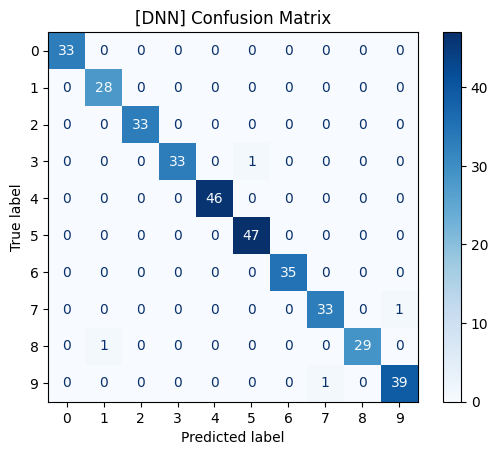

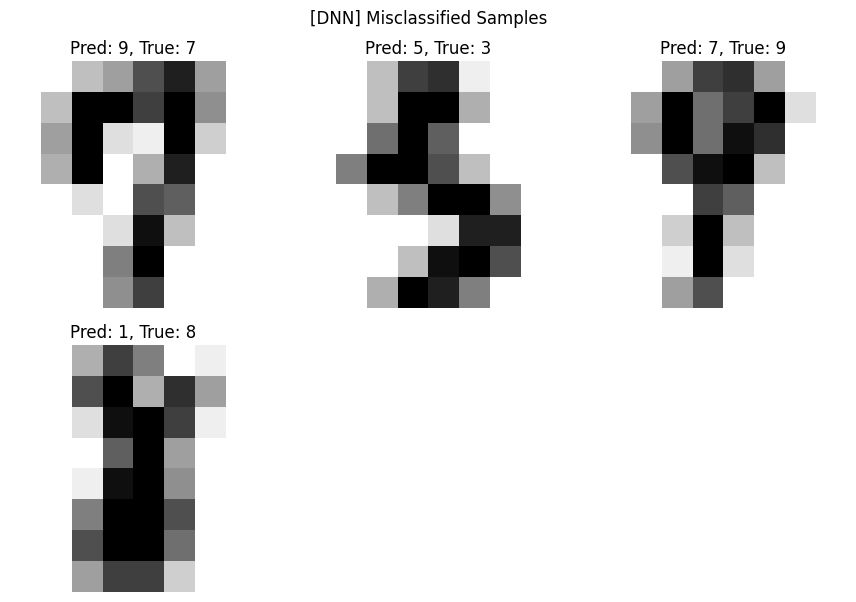

In [30]:
# 외전. confusion_matrix 출력, 잘못 분류된 샘플 시각화

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# confusion matrix 출력
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues', values_format='d')
plt.title("[DNN] Confusion Matrix")
plt.show()

# 잘못 분류된 샘플 시각화
wrong_idx = [i for i, (p, t) in enumerate(zip(all_preds, all_labels)) if p != t]

if wrong_idx:
    plt.figure(figsize=(9, 9))
    for i, idx in enumerate(wrong_idx[:9]):  # 앞에서 9개만 시각화
        img = X_test[idx].reshape(8, 8)
        pred = all_preds[idx]
        true = all_labels[idx]

        plt.subplot(3, 3, i + 1)
        plt.imshow(img, cmap='gray_r', interpolation='nearest')
        plt.title(f"Pred: {pred}, True: {true}")
        plt.axis('off')

    plt.suptitle("[DNN] Misclassified Samples")
    plt.tight_layout()
    plt.show()
else:
    print("[DNN] 모든 샘플이 정확히 분류되었습니다.")

#### 외전. CNN으로 해보기

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [20]:
# 데이터 로드
digits = datasets.load_digits()
X = digits.images  # (1797, 8, 8)
y = digits.target

In [21]:
# 정규화: 0~1 범위로 맞추기
X = X / 16.0  # 픽셀 값은 원래 0~16
X = X.reshape(-1, 1, 8, 8)  # Conv2d 입력 형식: (batch_size, channels, height, width)


In [22]:
# train/test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tensor로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [26]:
# DataLoader
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)


In [27]:
# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # (16, 8, 8)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (16, 4, 4)
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # (32, 4, 4)
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # (32, 2, 2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(32 * 2 * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc_layer(x)
        return x

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [28]:
# 학습
for epoch in range(20):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"[CNN] Epoch {epoch+1:2d} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")


[CNN] Epoch  1 | Loss: 2.2411 | Accuracy: 0.2797
[CNN] Epoch  2 | Loss: 1.7014 | Accuracy: 0.6945
[CNN] Epoch  3 | Loss: 0.7809 | Accuracy: 0.8483
[CNN] Epoch  4 | Loss: 0.4403 | Accuracy: 0.8831
[CNN] Epoch  5 | Loss: 0.3170 | Accuracy: 0.9130
[CNN] Epoch  6 | Loss: 0.2325 | Accuracy: 0.9402
[CNN] Epoch  7 | Loss: 0.1946 | Accuracy: 0.9464
[CNN] Epoch  8 | Loss: 0.1690 | Accuracy: 0.9506
[CNN] Epoch  9 | Loss: 0.1468 | Accuracy: 0.9596
[CNN] Epoch 10 | Loss: 0.1261 | Accuracy: 0.9617
[CNN] Epoch 11 | Loss: 0.1181 | Accuracy: 0.9638
[CNN] Epoch 12 | Loss: 0.1026 | Accuracy: 0.9694
[CNN] Epoch 13 | Loss: 0.0918 | Accuracy: 0.9722
[CNN] Epoch 14 | Loss: 0.0822 | Accuracy: 0.9784
[CNN] Epoch 15 | Loss: 0.0686 | Accuracy: 0.9805
[CNN] Epoch 16 | Loss: 0.0650 | Accuracy: 0.9833
[CNN] Epoch 17 | Loss: 0.0573 | Accuracy: 0.9868
[CNN] Epoch 18 | Loss: 0.0658 | Accuracy: 0.9819
[CNN] Epoch 19 | Loss: 0.0495 | Accuracy: 0.9875
[CNN] Epoch 20 | Loss: 0.0449 | Accuracy: 0.9910


In [29]:
# 평가
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

test_loss /= total
test_acc = correct / total
test_f1 = f1_score(all_labels, all_preds, average='macro')

print(f"\n[CNN] 최종 평가")
print(f" - Loss     : {test_loss:.4f}")
print(f" - Accuracy : {test_acc:.4f}")
print(f" - F1-score : {test_f1:.4f}")


[CNN] 최종 평가
 - Loss     : 0.0522
 - Accuracy : 0.9889
 - F1-score : 0.9886


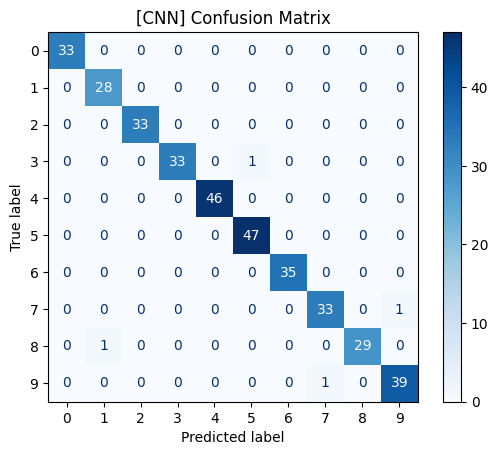

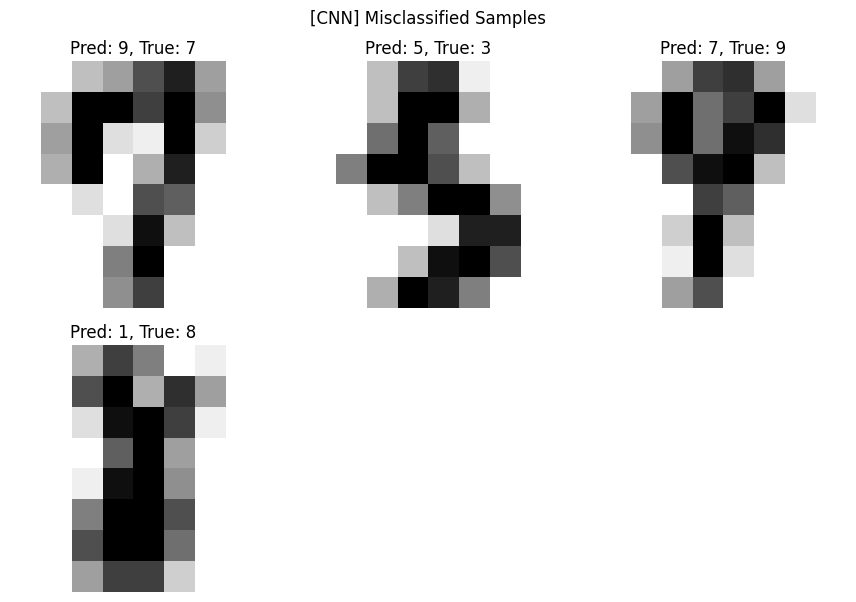

In [33]:
# 외전. confusion_matrix 출력, 잘못 분류된 샘플 시각화

# confusion matrix 출력
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues', values_format='d')
plt.title("[CNN] Confusion Matrix")
plt.show()

# 잘못 분류된 샘플 시각화
wrong_idx = [i for i, (p, t) in enumerate(zip(all_preds, all_labels)) if p != t]

if wrong_idx:
    plt.figure(figsize=(9, 9))
    for i, idx in enumerate(wrong_idx[:9]):  # 앞에서 9개만 시각화
        # CNN용 이미지는 (1, 8, 8) → (8, 8)로 변환 필요
        img = X_test[idx].squeeze()

        pred = all_preds[idx]
        true = all_labels[idx]

        plt.subplot(3, 3, i + 1)
        plt.imshow(img, cmap='gray_r', interpolation='nearest')
        plt.title(f"Pred: {pred}, True: {true}")
        plt.axis('off')

    plt.suptitle("[CNN] Misclassified Samples")
    plt.tight_layout()
    plt.show()
else:
    print("[CNN] 모든 샘플이 정확히 분류되었습니다.")